In [1]:
import ast
import warnings
import textwrap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# For better visualizations
sns.set(style="ticks", palette="muted", color_codes=True)

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [2]:
df=pd.read_csv("qatarairways_tweets_sentiments_with_keywords_topics.csv",
               parse_dates=['date'])

In [3]:
df.head(3)

,link,text,date,Likes,Comments,hashtags,users,cleaned_text,sntmnt_lbl,score,keybert_kw,yake_kw,keywords,topic_name
0,https://twitter.com/juliet_gough/status/174158...,It was fantastic service onboard. I'm so impre...,2023-12-31 22:23:00+00:00,0,0,[],juliet_gough,fantastic service onboard impressed thank,positive,0.989524,"service onboard,fantastic service,impressed thank","fantastic service,service onboard,onboard impr...","service onboard,impressed thank,fantastic serv...",13_fantastic_crew_movies_amazing
1,https://twitter.com/theamaeestales/status/1741...,@qrsupport is there a problem with your app? I...,2023-12-31 19:51:00+00:00,0,0,[],theamaeestales,problem app not login account,negative,0.781741,"app login,account,problem","problem app,login account,problem,account,app","app,account,app login,login account,problem ap...",113_password_otp_login_reset
2,https://twitter.com/rvvaradan/status/174143019...,I have reported the incident. Hoping to get a ...,2023-12-31 12:04:00+00:00,1,3,[],rvvaradan,report incident hope get resolution soon,neutral,0.689427,"report incident,hope resolution,soon","report incident,incident hope,report,incident,...","soon,incident,hope resolution,report,incident ...",31_complaint_appeal_complain_formal


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62153 entries, 0 to 62152
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   link          62153 non-null  object             
 1   text          62153 non-null  object             
 2   date          62153 non-null  datetime64[ns, UTC]
 3   Likes         62153 non-null  int64              
 4   Comments      62153 non-null  int64              
 5   hashtags      62153 non-null  object             
 6   users         62153 non-null  object             
 7   cleaned_text  62153 non-null  object             
 8   sntmnt_lbl    62153 non-null  object             
 9   score         62153 non-null  float64            
 10  keybert_kw    62153 non-null  object             
 11  yake_kw       62153 non-null  object             
 12  keywords      62153 non-null  object             
 13  topic_name    62153 non-null  object             
dtypes: dat

In [5]:
df['topic_name'].value_counts().nlargest(25)

topic_name
-1_ground_stranded_shame_rebook                  26268
0_processed_bank_transaction_28                   1922
1_damaged_delivered_bags_tracing                  1263
2_refunds_processed_agency_amount                 1206
3_missing_damaged_bags_baggages                   1003
4_select_seats_selection_seat                      779
5_refunded_refunds_refound_sce                     677
6_rebooking_jnb_canceled_rebook                    625
7_star_world_phx_worlds                            575
8_pcr_labs_rt_require                              514
9_treating_blah_company_satisfaction               498
10_negative_covid_testing_nhs                      450
11_chennai_indian_goa_hyderabad                    436
12_promo_code_promotion_discount                   417
13_fantastic_crew_movies_amazing                   396
14_pakistan_lahore_islamabad_karachi               377
15_resume_mumbai_chennai_operating                 355
16_meal_meals_vegetarian_food                      310

In [6]:
def top_20_kw_by_topic(topic_num):

    return (
        df.query(f"topic_name.str.contains(r'^{topic_num}_') and sntmnt_lbl!='neutral'")
        .loc[:, ['keywords', 'sntmnt_lbl']]
        .assign(keywords=lambda x: x['keywords'].str.split(","))
        .explode(column='keywords')
        .groupby(['keywords', 'sntmnt_lbl']).size()
        .unstack('sntmnt_lbl')
        .reindex(columns=['negative', 'positive'])
        .astype('Int64')
        .fillna(0)
        .assign(total=lambda x: x['negative']+x['positive'])
        .nlargest(20, columns='total')
        .drop('total', axis=1)
    )

In [7]:
def kw_sntmnt_timeline_by_topic(topic_num):
    
    start=df['date'].dt.date.min()
    end=df['date'].dt.date.max()

    return (
        df.query(f"topic_name.str.contains(r'^{topic_num}_') and sntmnt_lbl!='neutral'")
        .assign(only_date=lambda x: pd.to_datetime(x['date'].dt.date))
        .groupby(['only_date', 'sntmnt_lbl']).size()
        .unstack('sntmnt_lbl')
        .assign(negative=lambda x: x['negative'] if 'negative' in x.columns else np.nan,
                positive=lambda x: x['positive'] if 'positive' in x.columns else np.nan)
        .reindex(pd.date_range(start, end), columns=['negative', 'positive'])
        .assign(negative=lambda x: x['negative'].astype("Int64"),
                positive=lambda x: x['positive'].astype("Int64"))
    )

In [8]:
topic_num=14

def get_ht_sntmnt_from_topic(topic_num):

    ht_df = (
        df.query(f"topic_name.str.contains(r'^{topic_num}_') and sntmnt_lbl!='neutral'")
        .loc[:, ['sntmnt_lbl', 'hashtags']]
        .assign(hashtags=lambda x: x['hashtags'].apply(ast.literal_eval))
        .explode(column='hashtags')
        .assign(hashtags=lambda x: x['hashtags'].str.lower())
        .dropna(subset='hashtags')
        .loc[lambda x: ~x['hashtags'].isin(['#qatarairways', '#qatar', '#qrsupport'])]
        .loc[lambda x: ~x['hashtags'].str.contains(r'^#[0-9]+$')]
        .groupby('sntmnt_lbl')['hashtags'].agg(lambda x: ' '.join(x))
    )

    # Negative hashtag
    try:
        neg_ht = ht_df.loc[lambda x: x.index=='negative'].values[0]
    except IndexError:
        neg_ht = 'no_hashtag'

    # Positive hashtag
    try:
        pos_ht = ht_df.loc[lambda x: x.index=='positive'].values[0]
    except IndexError:
        pos_ht = 'no_hashtag'

    return neg_ht, pos_ht

In [9]:
def analyze_topic(topic_num):

    # https://www.geeksforgeeks.org/how-to-create-different-subplot-sizes-in-matplotlib/

    fig = plt.figure()
    fig.set_figheight(7.8)
    fig.set_figwidth(12)

    ax0 = plt.subplot2grid(shape=(2, 4), loc=(0, 0))
    ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 1), colspan=3)
    ax2 = plt.subplot2grid(shape=(2, 4), loc=(1, 0), colspan=2)
    ax3 = plt.subplot2grid(shape=(2, 4), loc=(1, 2), colspan=2)

    # Colors for sentiment
    color=['r', 'green']

    # Create Top 20 keyword Bargraph
    ################################

    top_20_kw_strings_df = top_20_kw_by_topic(topic_num=topic_num)

    # Plot bargraph
    top_20_kw_strings_df.plot(kind='barh', 
                                stacked=True, 
                                edgecolor='k', 
                                ax=ax0, 
                                color=color, 
                                legend=None)

    ax0.set_title(f"Top 20 Keywords")

    # Create keyword frequncy timeline
    ##################################

    kw_sntmnt_timeline_df = kw_sntmnt_timeline_by_topic(topic_num=topic_num)

    kw_sntmnt_timeline_df.plot(ax=ax1, 
                            linestyle="", 
                            marker='.', 
                            alpha=0.7, 
                            color=color, 
                            legend=None)

    ax1.set_title(f"Keyword timeline")
    ax1.set_xlabel("")
    
    max_ylim=kw_sntmnt_timeline_by_topic(topic_num).max().max()

    if  max_ylim < 10: 
        ax1.set_ylim(0, 10)
        ax1.set_yticks(range(0, 12, 2))

    # Highlighting Qatar flight ban time period
    # ax1.fill_between(x=("2020-03-18", "2020-04-01"), y1=0, y2=max_ylim+2, color='b', alpha = 0.5)

    # Hashtag Worldclouds by sentiment
    ##################################
    
    neg_ht, pos_ht = get_ht_sntmnt_from_topic(topic_num)

    for ht, ax, cmap, title in zip([neg_ht, pos_ht],
                             [ax2, ax3],
                             ['YlOrRd', 'Greens'],
                             ["#negativehastags", "#positivehashtags"]):

        wordcloud = WordCloud(width=600, height=350, colormap=cmap).generate(ht)
        
        ax.set_title(title)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.grid(None)
        

    labels=['negative', 'positive']
    fig.legend(labels, loc='center', bbox_to_anchor=(0.88, 0.92), ncol=len(labels), 
               bbox_transform=fig.transFigure)

    title=df.query(f"topic_name.str.contains(r'^{topic_num}_')")['topic_name'].unique()[0]

    plt.suptitle(title, fontweight='bold', fontsize=20)
    plt.tight_layout()
    plt.show()

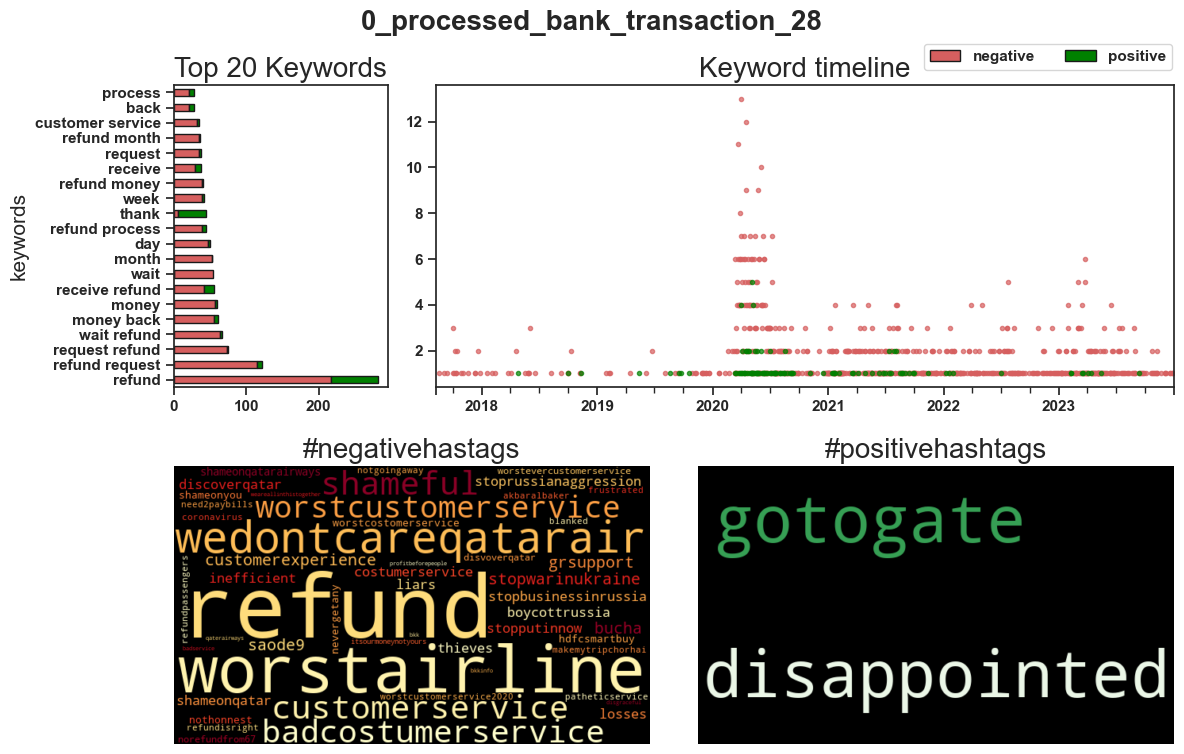

In [10]:
analyze_topic(topic_num=0)

In [17]:
(
    df.query("topic_name.str.contains(r'^0_')")
    .query("sntmnt_lbl=='positive' and hashtags.str.contains('disappointed', case=False)")
    .loc[:, 'text'].values[0]
)

'Thank you for replying after 300 years. I’ll be ever more grateful if you refunded my money. Your customer service isn’t really doing your customers any service at all. #Disappointed'

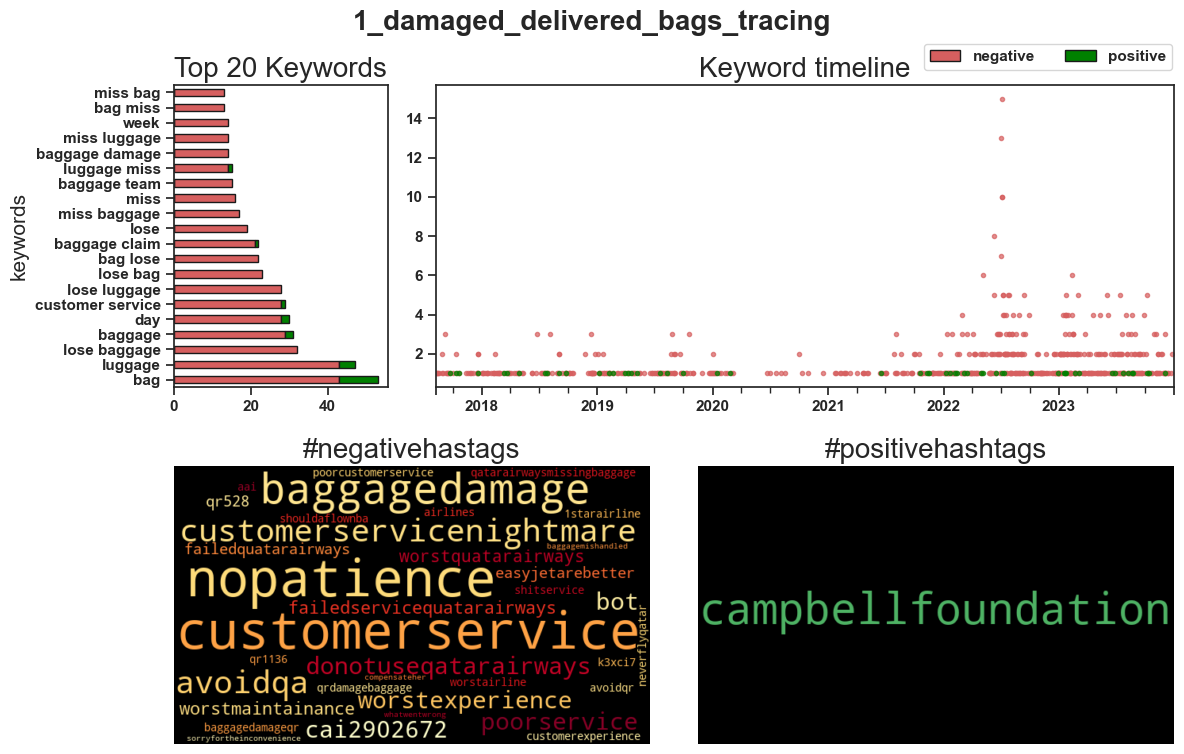

In [19]:
analyze_topic(topic_num=1)

In [20]:
(
    df.query("topic_name.str.contains(r'^1_')")
    .query("sntmnt_lbl=='positive' and hashtags.str.contains('campbell', case=False)")
    .loc[:, 'text'].values[0]
)

'Hi guys. Thanks for getting back to me. All sorted - excess baggage checkin for a charity flying tonight. #CampbellFoundation'

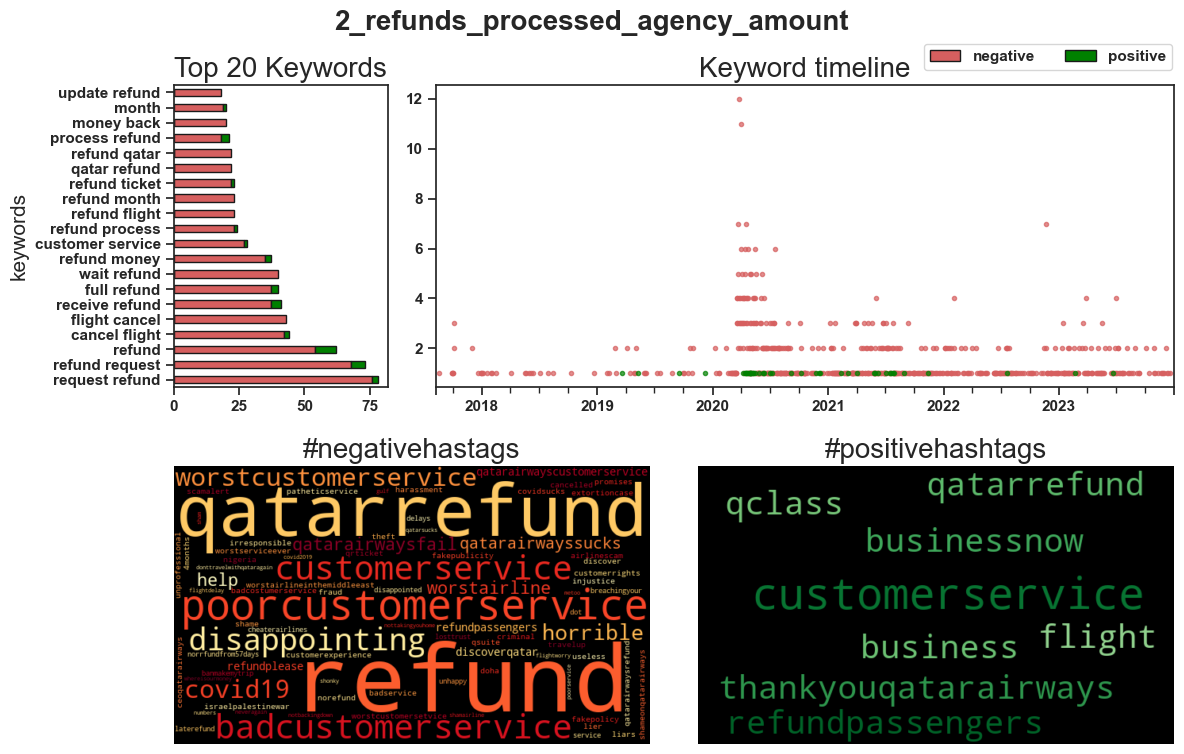

In [21]:
analyze_topic(topic_num=2)

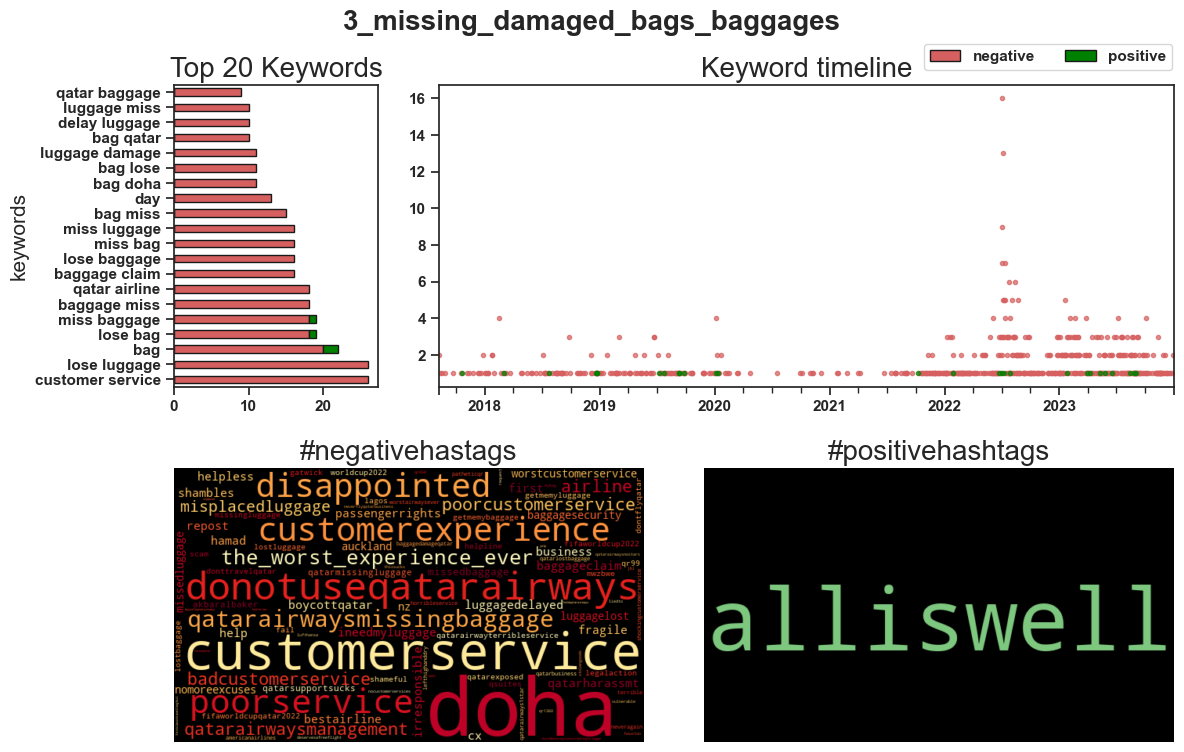

In [22]:
analyze_topic(topic_num=3)

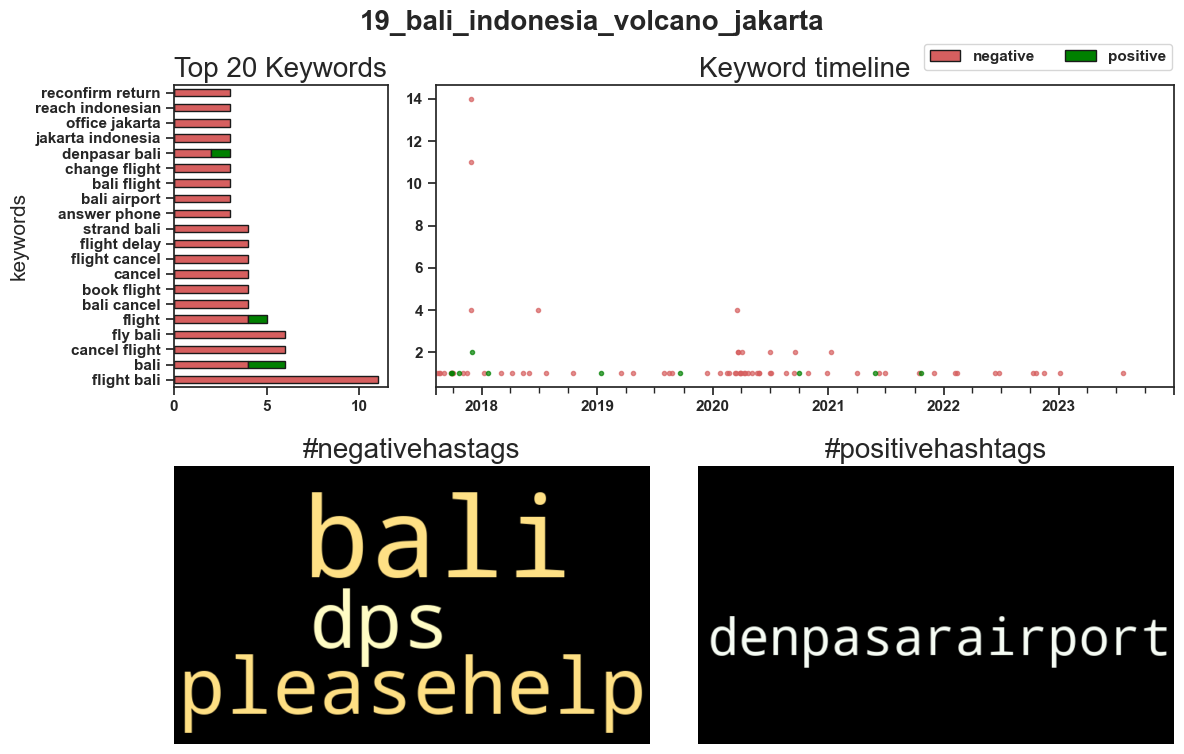

In [115]:
analyze_topic(topic_num=19)

In [188]:
temp_df = (
    df.query("~topic_name.str.contains(r'^-1_')")
    .assign(month=lambda x: x['date'].dt.month.astype('string').str.zfill(2),
            year=lambda x: x['date'].dt.year.astype('string'),
            year_month = lambda x: x['year']+"_"+x['month'])
    .groupby(['year_month', 'topic_name']).size()
    .loc[lambda x: x>1]
    .reset_index()
    .rename(columns={0 : 'count'})
    .assign(topic_rank=lambda x: (x.groupby(['year_month'])['count']
                                  .rank('dense', ascending=False)
                                  .astype('int')))
    .loc[lambda x: x['topic_rank'].eq(1)]
    .drop('topic_rank', axis=1)
    .nlargest(20, columns='count')
    # .sort_values('year_month', ignore_index=True)
)

temp_df

,year_month,topic_name,count
1970,2020_04,0_processed_bank_transaction_28,204
2103,2020_05,0_processed_bank_transaction_28,172
1768,2020_03,0_processed_bank_transaction_28,168
4522,2022_07,1_damaged_delivered_bags_tracing,146
2250,2020_06,0_processed_bank_transaction_28,125
187,2017_11,19_bali_indonesia_volcano_jakarta,90
4951,2023_01,1_damaged_delivered_bags_tracing,80
3450,2021_07,18_quarantine_vaccinated_unvaccinated_vaccine,73
2363,2020_07,0_processed_bank_transaction_28,71
5114,2023_03,0_processed_bank_transaction_28,61


In [76]:
# topic_df = (
#     df['topic_name'].str.extract(r'(^-*[0-9]+)_(.+)$')
#     .drop_duplicates(ignore_index=True)
#     .rename(columns={0:'topic_num', 1:'topic_name'})
#     .assign(topic_name=lambda x: (x['topic_name']
#                                   .replace(r'_*[0-9]+_*', '_', regex=True)
#                                   .replace("__", "_", regex=True)
#                                   .replace("^_|_$", "", regex=True)))
# )


# topic_df

In [69]:
# # https://stackoverflow.com/a/67242181/15937542

# from fuzzywuzzy import fuzz

# for d in topic_df.topic_name.unique():
#     # compute Levensthein distance
#     # and set to True if >= a limit
#     # (you may have to play around with it)
#     topic_df[d] = topic_df['topic_name'].apply(
#         lambda x : fuzz.ratio(x, d) >= 60
#     )
#     # set a name for the group
#     # here, simply the shortest
#     m = np.min(topic_df[topic_df[d]==True].topic_name)
#     # assign the group
#     topic_df.loc[topic_df.topic_name==d, 'group'] = m

In [75]:
(
    topic_df.query("group=='password_login_log_loading'")
)

,topic_num,topic_name,fantastic_crew_movies_amazing,group,password_otp_login_reset,complaint_appeal_complain_formal,emirates_etihad_emiratessupport_dubai,rebooking_reticketing_bribed,ground_stranded_shame_rebook,star_world_phx_worlds,...,redeem_qmiles_nooks_tedeem,unhappily_extrordinary_dohatogether_cardifftogether,qmiles_cliam,coustmer_virtual,rescheduled_sheduled_qr_qr,recredit_hang_set_awaiting,edinburgh_vz_ln_qr_gatwick,maps_pnh,iran_airspace_iranian_iraq,button_submit_submitting_cookies
1,113,password_otp_login_reset,False,password_login_log_loading,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40,193,password_login_log_loading,False,password_login_log_loading,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
